In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import joblib

In [2]:
df = pd.read_csv('../Data/Real_Estate_Model.csv')

In [3]:
df[['price', 'bath', 'house_size', 'bed', 'Price_per_sqft']].corr()

,price,bath,house_size,bed,Price_per_sqft
price,1.000000,0.461083,0.460242,0.275841,0.628017
bath,0.461083,1.000000,0.724302,0.573037,-0.119530
house_size,0.460242,0.724302,1.000000,0.659245,-0.272056
bed,0.275841,0.573037,0.659245,1.000000,-0.266213
Price_per_sqft,0.628017,-0.119530,-0.272056,-0.266213,1.000000


Variable Selection and train model

In [4]:
#change data type of city, state, and zip_code to category
df['city'] = df['city'].astype('category')
df['state'] = df['state'].astype('category')
df['zip_code'] = df['zip_code'].astype('category')
df['bed'] = df['bed'].astype(int)
df['bath'] = df['bath'].astype(int)

In [5]:
df.dtypes

status              object
price              float64
bed                  int64
bath                 int64
city              category
state             category
zip_code          category
house_size         float64
Price_per_sqft     float64
dtype: object

Base Model

In [6]:
X = df[['bath', 'bed', 'house_size', 'state', 'city']]
y = df['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state=6)
base_model = xgb.XGBRegressor(enable_categorical=True).fit(X_train, Y_train)
base_pred = base_model.predict(X_test)
mae_base = mean_absolute_error(Y_test, base_pred)  # Mean Absolute Error
rmse_base = np.sqrt(mean_squared_error(Y_test, base_pred))  # Root Mean Squared Error
r2_base = r2_score(Y_test, base_pred)  # R-squared
mape_base = np.mean(np.abs((Y_test - base_pred) / Y_test)) * 100  # Mean Absolute Percentage Error
print(f"MAE: {mae_base}")
print(f"RMSE: {rmse_base}")
print(f"MAPE: {mape_base}")
print(f"R2: {r2_base}")
#learning_rate=0.1, max_depth=3, n_estimators=50

MAE: 83998.45450349248
RMSE: 116517.001734712
MAPE: 29.349247701331045
R2: 0.7119814417129566


Feature Importance

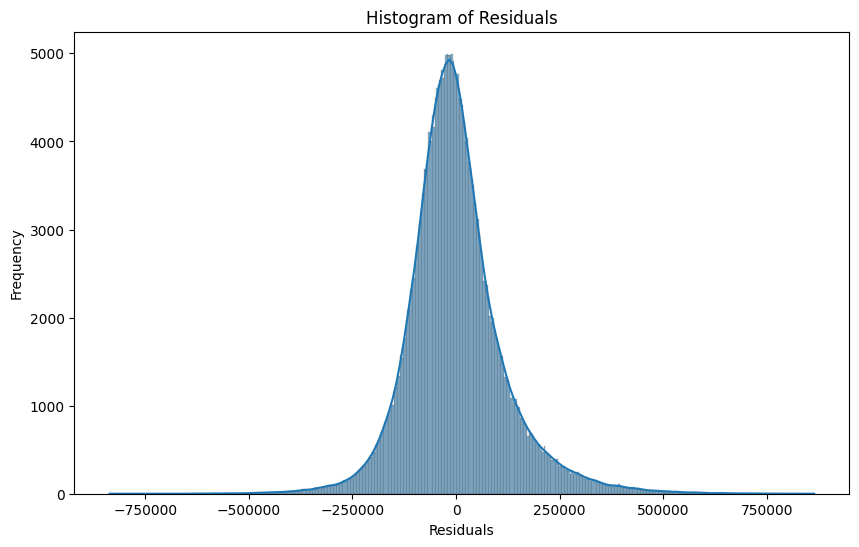

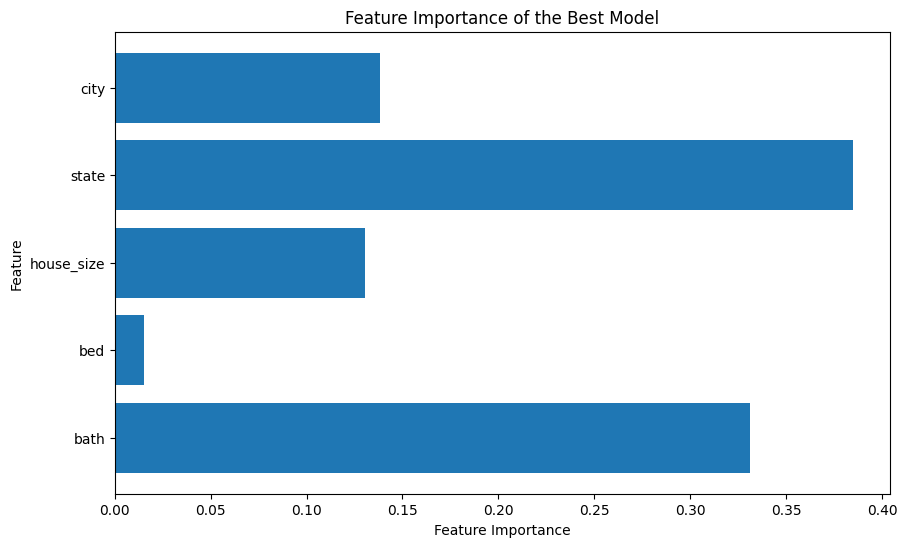

In [8]:
residuals = Y_test - base_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

feature_importance = base_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

Hyper parameter tuning: Find optimal combination of parameters to decrease the average percentage error rate. It includes cross validation in the process.  

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [1, 6],
    'learning_rate': [0.1, 0.5],
    'n_estimators': [600, 700]
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method='gpu_hist', enable_categorical=True), param_grid=param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search.fit(X_train, Y_train)

best_model = grid_search.best_estimator_
best_pred = best_model.predict(X_test)

mae_best = mean_absolute_error(Y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(Y_test, best_pred))
mape_best = np.mean(np.abs((Y_test - best_pred) / Y_test)) * 100
r2_best = r2_score(Y_test, best_pred)

print(f"MAE: {mae_best}, RMSE: {rmse_best}, MAPE: {mape_best}, R2: {r2_best}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\tomas\OneDrive\Documents\Personal\House-Price-Prediction-App\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:31:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\tomas\OneDrive\Documents\Personal\House-Price-Prediction-App\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\tomas

MAE: 75393.76976800355, RMSE: 109568.33295753444, MAPE: 25.29636588350507, R2: 0.7453099498209881


Best Model

In [9]:
best_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=800, enable_categorical=True).fit(X_train, Y_train)
best_pred = best_model.predict(X_test)

mae_best = mean_absolute_error(Y_test, best_pred)
rmse_best = np.sqrt(mean_squared_error(Y_test, best_pred))
mape_best = np.mean(np.abs((Y_test - best_pred) / Y_test)) * 100
r2_besst = r2_score(Y_test, best_pred)
print(f"MAE: {mae_best}, RMSE: {rmse_best}, MAPE: {mape_best}, R2: {r2_besst}")


MAE: 73231.480444976, RMSE: 106592.24842821828, MAPE: 24.715326002450986, R2: 0.7589577807215362


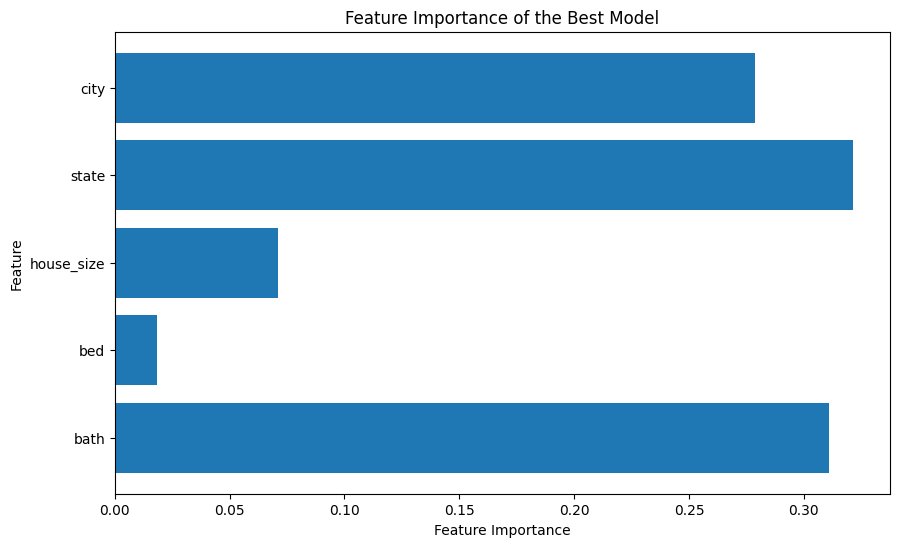

In [7]:
best_feature_importance = best_model.feature_importances_
features = X.columns
plt.figure(figsize=(10, 6))
plt.barh(features, best_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Best Model')
plt.show()

In [9]:
bins = [0, 300_000, 400_000, 500_000, 1_000_000, float('inf')]
labels = ['<300k', '300k-400k', '400k-500k', '500k-1M', '1M+']

price_segments = pd.cut(Y_test, bins=bins, labels=labels)
segment_df = pd.DataFrame({'actual': Y_test, 'pred': best_pred, 'segment': price_segments})
segment_df['pct_error'] = np.abs(segment_df['actual'] - segment_df['pred']) / segment_df['actual'] * 100

mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()
print(mape_by_segment)

segment
<300k        37.254866
300k-400k    16.742555
400k-500k    15.401889
500k-1M      15.486529
1M+                NaN
Name: pct_error, dtype: float64


C:\Users\tomas\AppData\Local\Temp\ipykernel_4028\1603868989.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mape_by_segment = segment_df.groupby('segment')['pct_error'].mean()


Save model

In [16]:
joblib.dump((best_model, X.columns), 'Best_Model.pkl')

['Best_Model.pkl']

Model for houses below 300k

[0]	validation_0-rmse:65769.96129
[1]	validation_0-rmse:63809.45692
[2]	validation_0-rmse:62120.51336
[3]	validation_0-rmse:60729.29524
[4]	validation_0-rmse:59476.07836
[5]	validation_0-rmse:58422.70502
[6]	validation_0-rmse:57582.50840
[7]	validation_0-rmse:56839.90235
[8]	validation_0-rmse:56193.46518
[9]	validation_0-rmse:55651.20420
[10]	validation_0-rmse:55144.82851
[11]	validation_0-rmse:54727.05715
[12]	validation_0-rmse:54337.53040
[13]	validation_0-rmse:54004.41681
[14]	validation_0-rmse:53674.04011
[15]	validation_0-rmse:53382.64942
[16]	validation_0-rmse:53167.96447
[17]	validation_0-rmse:52952.53736
[18]	validation_0-rmse:52757.13932
[19]	validation_0-rmse:52568.49176
[20]	validation_0-rmse:52435.00596
[21]	validation_0-rmse:52287.43459
[22]	validation_0-rmse:52167.47867
[23]	validation_0-rmse:52082.56963
[24]	validation_0-rmse:51974.10159
[25]	validation_0-rmse:51878.11736
[26]	validation_0-rmse:51784.15810
[27]	validation_0-rmse:51683.03139
[28]	validation_0-rmse:51610.6

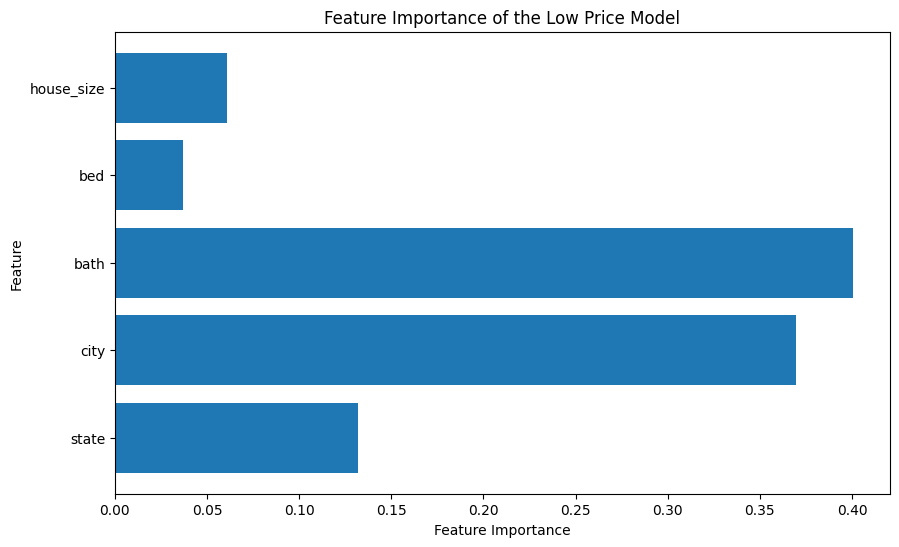

In [12]:
low_model = df[df['price'] <= 300000]
X_low = low_model[['state', 'city', 'bath', 'bed', 'house_size']]
y_low = low_model['price']
X_low_train, X_low_test, Y_low_train, Y_low_test = train_test_split(X_low, y_low, test_size=0.2, random_state=52)
xgb_low_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=10, n_estimators=800, tree_method = 'hist', early_stopping_rounds = 50,  enable_categorical=True).fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
low_pred = xgb_low_model.predict(X_low_test)
mae_low = mean_absolute_error(Y_low_test, low_pred)
rmse_low = np.sqrt(mean_squared_error(Y_low_test, low_pred))
mape_low = np.mean(np.abs((Y_low_test - low_pred) / Y_low_test)) * 100
r2_low = r2_score(Y_low_test, low_pred)
print(f"MAE: {mae_low}, RMSE: {rmse_low}, MAPE: {mape_low}, R2: {r2_low}")
low_feature_importance = xgb_low_model.feature_importances_
features = X_low.columns
plt.figure(figsize=(10, 6))
plt.barh(features, low_feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of the Low Price Model')
plt.show()

Hyper parameter tuning for model with houses below $300,000. It includes cross validation in the process.

In [ ]:
param_grid_low = {
    'max_depth': [2, 4],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [200, 400]
}
grid_search_low = GridSearchCV(estimator=xgb_low_model, param_grid=param_grid_low, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
grid_search_low.fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
print("Best parameters found for low price model: ", grid_search_low.best_params_)
best_low_model = grid_search_low.best_estimator_
best_low_pred = best_low_model.predict(X_low_test)
mae_low = mean_absolute_error(Y_low_test, best_low_pred)
rmse_low = np.sqrt(mean_squared_error(Y_low_test, best_low_pred))
mape_low = np.mean(np.abs((Y_low_test - best_low_pred) / Y_low_test)) * 100
r2_low = r2_score(Y_low_test, best_low_pred)
print(f"MAE: {mae_low}, RMSE: {rmse_low}, MAPE: {mape_low}, R2: {r2_low}")


In [14]:

print("Best parameters found: ", grid_search_low.best_params_)
print("Best score: ", grid_search_low.best_score_)

Best parameters found:  {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 400}
Best score:  -0.256232974216861


In [13]:
best_low_model = xgb.XGBRegressor(learning_rate=0.1, max_depth=8, n_estimators=800, tree_method = 'hist', early_stopping_rounds = 50,  enable_categorical=True).fit(X_low_train, Y_low_train, eval_set=[(X_low_test, Y_low_test)], verbose=1)
best_low_pred = best_low_model.predict(X_low_test)
mae_low_best = mean_absolute_error(Y_low_test, best_low_pred)
rmse_low_best = np.sqrt(mean_squared_error(Y_low_test, best_low_pred))
mape_low_best = np.mean(np.abs((Y_low_test - best_low_pred) / Y_low_test)) * 100
r2_low_best = r2_score(Y_low_test, best_low_pred)
print(f"MAE: {mae_low_best}, RMSE: {rmse_low_best}, MAPE: {mape_low_best}, R2: {r2_low_best}")
# low_feature_importance = best_low_model.feature_importances_

# features = X_low.columns

[0]	validation_0-rmse:65932.49499
[1]	validation_0-rmse:64104.09300
[2]	validation_0-rmse:62529.53014
[3]	validation_0-rmse:61186.24943
[4]	validation_0-rmse:60098.57080
[5]	validation_0-rmse:59143.35636
[6]	validation_0-rmse:58374.06799
[7]	validation_0-rmse:57666.59070
[8]	validation_0-rmse:57102.68406
[9]	validation_0-rmse:56624.79170
[10]	validation_0-rmse:56191.11719
[11]	validation_0-rmse:55784.34532
[12]	validation_0-rmse:55413.42551
[13]	validation_0-rmse:55110.48067
[14]	validation_0-rmse:54856.50533
[15]	validation_0-rmse:54613.22541
[16]	validation_0-rmse:54412.07642
[17]	validation_0-rmse:54190.48109
[18]	validation_0-rmse:54045.59963
[19]	validation_0-rmse:53884.22233
[20]	validation_0-rmse:53732.22656
[21]	validation_0-rmse:53615.98431
[22]	validation_0-rmse:53489.32767
[23]	validation_0-rmse:53405.54856
[24]	validation_0-rmse:53301.87826
[25]	validation_0-rmse:53212.32679
[26]	validation_0-rmse:53136.63261
[27]	validation_0-rmse:53067.66427
[28]	validation_0-rmse:52983.6

Save low model

In [15]:
joblib.dump((best_model, X_low), 'Best_low_model.pkl')

['Best_low_model.pkl']